# New simulator tests and MAP

This notebook aims testing the new simulator already in the context of a fully assembled IMAGINE pipeline

In [1]:
import os, sys
sys.path.append('../')

import imagine as img
import imagine_snrs as img_snrs
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

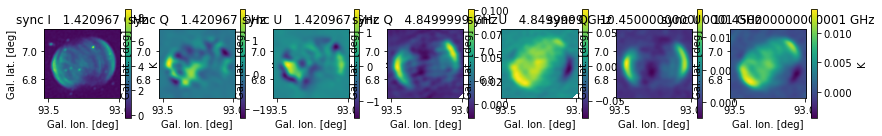

In [2]:
measurements = img.observables.Measurements(
    img_snrs.datasets.SNR_DA530_I_1420MHz(crop_lon=62, crop_lat=62),
    img_snrs.datasets.SNR_DA530_Q_1420MHz(crop_lon=62, crop_lat=62),
    img_snrs.datasets.SNR_DA530_U_1420MHz(crop_lon=62, crop_lat=62),
    img_snrs.datasets.SNR_DA530_Q_4850MHz(crop_lon=62, crop_lat=62),
    img_snrs.datasets.SNR_DA530_U_4850MHz(crop_lon=62, crop_lat=62),
    img_snrs.datasets.SNR_DA530_Q_10450MHz(crop_lon=62, crop_lat=62),
    img_snrs.datasets.SNR_DA530_U_10450MHz(crop_lon=62, crop_lat=62))
plt.figure(figsize=(14,2))
measurements.show()

In [3]:
L = 75*u.pc; N = 160
grid = img.fields.UniformGrid(box=[[-L,L],[-L,L],[-L,L]],
                              resolution=[N, N, N])

In [4]:
from imagine.fields import FieldFactory
from imagine.priors import FlatPrior, GaussianPrior

L_shift = 70*u.pc

te_factory = FieldFactory(grid=grid,
                          field_class=img_snrs.fields.SNRThermalElectrons,
                          active_parameters=[],#'initial_electron_density'],
                          default_parameters={'initial_electron_density': 0.01*u.cm**-3,
                                              'shell_V0':0.0153*u.pc/u.yr, 
                                              'shell_a': 1.3, 
                                              'shell_b': 10,
                                              'elapsed_time': 1300*u.yr,
                                              'shell_radius': 35*u.pc},
                          priors={'initial_electron_density': FlatPrior(1e-4, 10, u.cm**-3),
                                  'shell_V0': FlatPrior(1e-3, 0.1, u.pc/u.yr),
                                  'shell_a': FlatPrior(0.5, 2), 
                                  'shell_b': FlatPrior(1, 50), 
                                  'elapsed_time': FlatPrior(500, 3000, u.yr),
                                  'shell_radius': FlatPrior(10, 60, u.pc)})

B_BFM_factory = FieldFactory(grid=grid,
                             field_class=img_snrs.fields.SNR_BFM_MagneticField,
                             active_parameters=['B', 'period', 'x_shift', 'y_shift'],
                             default_parameters={'B': 1*u.microgauss,
                                                 'alpha': 0*u.rad,
                                                 'beta': 0*u.rad},
                             priors={'B': FlatPrior(0, 10, u.microgauss),
                                     'x_shift': FlatPrior(-L_shift, L_shift),
                                     'y_shift': FlatPrior(-L_shift, L_shift),
                                     'period': FlatPrior(10,120, u.pc)})

sqrt2 = np.sqrt(2)
pi = np.pi*u.rad
class HelicalMagneticField(img.fields.MagneticField):
    """
    Magnetic field of a supernova remnant
    """
    NAME = 'SNR_helical_magnetic_field'
    PARAMETER_NAMES = ['B', 'period']
    DEPENDENCIES_LIST = [img_snrs.fields.SNRThermalElectrons]

    def compute_field(self, seed):
        
        # Helical parallel to x
        Bx = np.ones(grid.x.shape) /sqrt2  * self.parameters['B']
        arg = pi*grid.x/self.parameters['period']
        By = np.cos(arg) /sqrt2 * self.parameters['B']
        Bz = np.sin(arg) /sqrt2 * self.parameters['B']

        # Transforms the initial field
        ne_obj = self.dependencies[img_snrs.fields.SNRThermalElectrons]
        Bx, By, Bz = ne_obj.field_transformer.transform_magnetic_field(Bx, By, Bz)

        B = np.empty(self.data_shape) << Bx.unit
        for i, Bc in enumerate([Bx, By, Bz]):
            B[:,:,:,i] = Bc

        return B

B_factory = FieldFactory(grid=grid,
                             field_class=HelicalMagneticField,
                             active_parameters=['B', 'period'],
                             priors={'B': FlatPrior(0, 10, u.microgauss),
                                     'period': FlatPrior(10,120, u.pc)})

CR_factory = FieldFactory(grid=grid, 
                          field_class=img_snrs.fields.EquipartitionCosmicRayElectrons,
                          active_parameters=(),
                          default_parameters={'cr_energy': 1*u.GeV, 'Ecr_Em': 1},
                          priors={'Ecr_Em': GaussianPrior(mu=1, sigma=0.1, 
                                                          xmin=1e-2, xmax=10)})


class LoSintegratorSettings(img.fields.DummyField):
    NAME = 'LoS_integrator_settings'
    FIELD_CHECKLIST = {'alpha': None,
                       'beta': None,
                       'gamma': None,
                       'distance': None}
    SIMULATOR_CONTROLLIST = {}

dummy_factory = img.fields.FieldFactory(grid=grid,
                                        field_class=LoSintegratorSettings, 
                                        active_parameters=('alpha','beta','gamma'),
                                        default_parameters={'distance': 11.3*u.kpc},
                                        priors={'alpha': img.priors.FlatPrior(-180, 180, u.deg, wrapped=True), 
                                                'beta': img.priors.FlatPrior(-90, 90, u.deg), 
                                                'gamma': img.priors.FlatPrior(-180, 180, u.deg, wrapped=True)})


In [5]:
simulator = img_snrs.simulators.LoS_integrator(measurements)

# masks = img.observables.Masks()
# for k in measurements:
#     mask = np.isfinite(measurements[k].data)
#     if np.all(mask):
#         continue
#     else:
#         masks.append(name=k, data=mask)

likelihood = img.likelihoods.SimpleLikelihood(measurements)#, mask_dict=masks)

In [6]:
Pipeline = img.pipelines.UltranestPipeline

pipeline = Pipeline(run_directory=os.path.join(img.rc['temp_dir'],'uniform_field'),
                    simulator=simulator, likelihood=likelihood,
                    factory_list=[dummy_factory, B_factory,
                                  CR_factory, te_factory])

In [7]:
pipeline.test()

Sampling centres of the parameter ranges.
	Evaluating point: [0.0, 0.0, 0.0, 5.0, 65.0]


/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


	Log-likelihood nan
	Total execution time:  22.17010885477066 s

Randomly sampling from prior.
	Evaluating point: [179.65458552 -47.50398415 -37.23093817   3.87910741  83.67206405]
	Log-likelihood nan
	Total execution time:  16.568161914125085 s

Randomly sampling from prior.
	Evaluating point: [156.79406549  62.335965   -67.2215339    5.2454816   58.77981832]
	Log-likelihood nan
	Total execution time:  16.363891487941146 s

Average execution time: 18.36738741894563 s


<Quantity 18.36738742 s>

In [9]:
pipeline.active_parameters

('LoS_integrator_settings_alpha',
 'LoS_integrator_settings_beta',
 'LoS_integrator_settings_gamma',
 'SNR_helical_magnetic_field_B',
 'SNR_helical_magnetic_field_period')

In [ ]:
pipeline.get_MAP()

In [ ]:
plt.figure(figsize=(12,4))
pipeline.MAP_simulation.show()
plt.figure(figsize=(12,4))
measurements.show()